In [1]:
%pip install open-webui


Defaulting to user installation because normal site-packages is not writeable
ERROR: Ignored the following versions that require a different python version: 0.1.124 Requires-Python <3.12.0a1,>=3.11; 0.1.125 Requires-Python <3.12.0a1,>=3.11; 0.2.0 Requires-Python <3.12.0a1,>=3.11; 0.2.0.dev1 Requires-Python <3.12.0a1,>=3.11; 0.2.0.dev2 Requires-Python <3.12.0a1,>=3.11; 0.2.0.dev3 Requires-Python <3.12.0a1,>=3.11; 0.2.0.dev4 Requires-Python <3.12.0a1,>=3.11; 0.2.1 Requires-Python <3.12.0a1,>=3.11; 0.2.2 Requires-Python <3.12.0a1,>=3.11; 0.2.3 Requires-Python <3.12.0a1,>=3.11; 0.2.4 Requires-Python <3.12.0a1,>=3.11; 0.2.5 Requires-Python <3.12.0a1,>=3.11; 0.3.0 Requires-Python <3.12.0a1,>=3.11; 0.3.1 Requires-Python <3.12.0a1,>=3.11; 0.3.10 Requires-Python <3.12.0a1,>=3.11; 0.3.12 Requires-Python <3.12.0a1,>=3.11; 0.3.13 Requires-Python <3.12.0a1,>=3.11; 0.3.14 Requires-Python <3.12.0a1,>=3.11; 0.3.15 Requires-Python <3.12.0a1,>=3.11; 0.3.16 Requires-Python <3.12.0a1,>=3.11; 0.3.17 Requir

In [ ]:
% pip install tensorflow requests matplotlib

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import os

In [3]:

from src.data.data_utils import (
    download_and_unzip_dataset,
    filter_dataset,
    filter_validation_dataset,
    preprocess_data,
)
from src.models.model_utils import build_pretext_task_model, build_downstream_task_model
from src.utils.plot_utils import plot_training_history, plot_predictions

In [2]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print("Num GPUs Available: ", len(physical_devices))

# Limit GPU memory growth (optional but helps avoid memory allocation issues)
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

# Optionally, you can set the GPU to be used for training:
tf.config.set_visible_devices(physical_devices[0], "GPU")

Num GPUs Available:  1


In [ ]:
download_and_unzip_dataset(
    url="https://www.kaggle.com/api/v1/datasets/download/akash2sharma/tiny-imagenet",
    output_dir="./",
)

In [ ]:
# Paths to dataset
data_dir = "/content/tiny-imagenet-200"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

num_classes_pretext_task = 4  # [0°, 90°, 180°, 270°]
num_classes_downstream_task = 2  # ["Fish", "Duck"]
target_labels = ["n01443537", "n01855672"]  # Codes for target classes (Fish, Duck)

### Pretext task

Our pretext task is to predict the rotation angle of an image.

In [8]:
# Load and preprocess training dataset
train_dataset = (
    tf.keras.utils.image_dataset_from_directory(
        train_dir, image_size=(64, 64), batch_size=None, label_mode=None
    )
    .map(preprocess_data)
    .batch(128)
    .shuffle(1000)
    .prefetch(tf.data.AUTOTUNE)
)

# Load and preprocess validation dataset
val_dataset = (
    tf.keras.utils.image_dataset_from_directory(
        val_dir, image_size=(64, 64), batch_size=None, label_mode=None
    )
    .map(preprocess_data)
    .batch(128)
    .prefetch(tf.data.AUTOTUNE)
)

# Load and preprocess test dataset
test_dataset = (
    tf.keras.utils.image_dataset_from_directory(
        test_dir, image_size=(64, 64), batch_size=None, label_mode=None
    )
    .map(preprocess_data)
    .batch(128)
    .prefetch(tf.data.AUTOTUNE)
)

Found 100000 files.
Found 10000 files.
Found 10000 files.


In [ ]:
model = build_pretext_task_model(num_classes_pretext_task)
model.summary()

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=5,  # Number of epochs with no improvement to wait
    restore_best_weights=True,  # Restore the model weights from the epoch with the best value of the monitored metric
)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)

# Fit the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping, reduce_lr],
)

In [ ]:
plot_training_history(history)

In [ ]:
model.save("../../models/pretext_task_model.keras")

### Downstream task

We will now use the pretrained model to predict the class of an image (Fish or Duck).

In [ ]:
# Functions to filter the dataset to include only the target classes

filter_dataset(
    "/content/tiny-imagenet-200/train",
    selected_labels=target_labels,
    target_dir="filtered_dataset/train",
)


filter_validation_dataset(
    "/content/tiny-imagenet-200/val",
    selected_labels=target_labels,
    target_dir="filtered_dataset/val",
)

In [6]:
# Function to preprocess the images for the downstream task
def preprocess(image, label):
    image = tf.image.resize(image, (64, 64))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [11]:
train_ds = (
    tf.keras.utils.image_dataset_from_directory(
        "filtered_dataset/train", image_size=(64, 64)
    )
    .map(preprocess)
    .shuffle(1000)
    .prefetch(tf.data.AUTOTUNE)
)
val_ds = (
    tf.keras.utils.image_dataset_from_directory(
        "filtered_dataset/val", image_size=(64, 64)
    )
    .map(preprocess)
    .shuffle(1000)
    .prefetch(tf.data.AUTOTUNE)
)

Found 1000 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


In [18]:
model = build_downstream_task_model(num_classes_downstream_task)

# Fit the model
history = model.fit(train_ds, validation_data=val_ds, epochs=40)

Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 53s 604ms/step - accuracy: 0.9542 - loss: 0.1175 - val_accuracy: 0.7200 - val_loss: 1.1716
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9668 - loss: 0.0996 - val_accuracy: 0.7300 - val_loss: 1.2446
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9856 - loss: 0.0496 - val_accuracy: 0.7300 - val_loss: 1.2568
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9851 - loss: 0.0523 - val_accuracy: 0.7400 - val_loss: 1.0270
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9950 - loss: 0.0340 - val_accuracy: 0.8100 - val_loss: 0.6622
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9943 - loss: 0.0310 - val_accuracy: 0.8000 - val_loss: 0.7362
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9993 - loss: 0.0167 - val_accuracy: 0.8000 - val_loss: 0.7026
Epoch 8/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9978 - loss: 0.0182 - val_accuracy: 0.8200 -

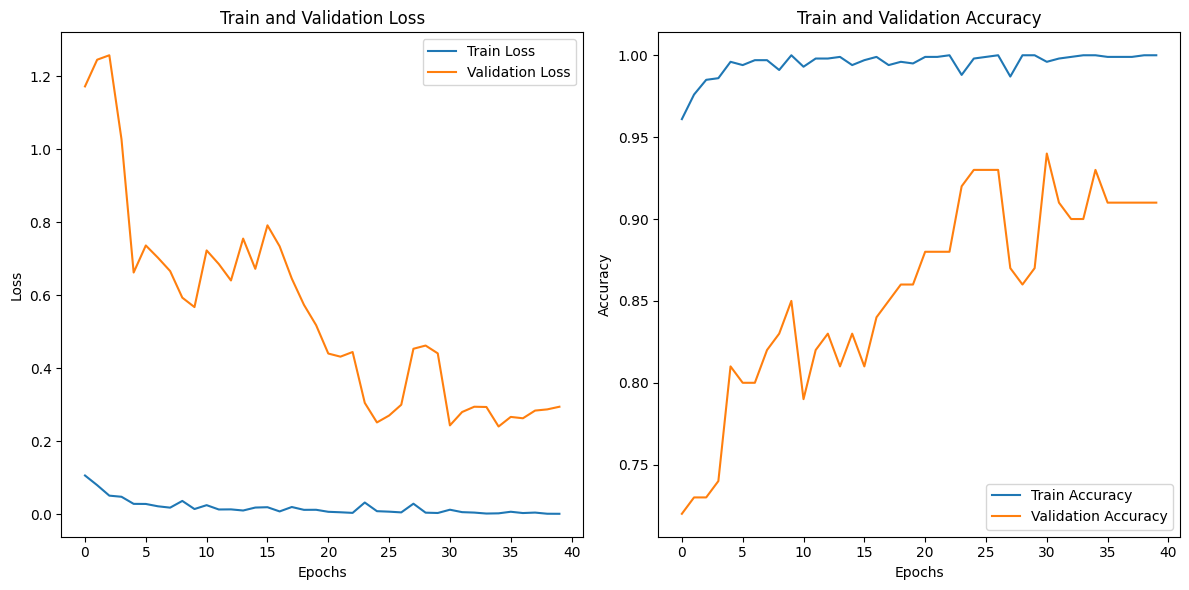

In [19]:
plot_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


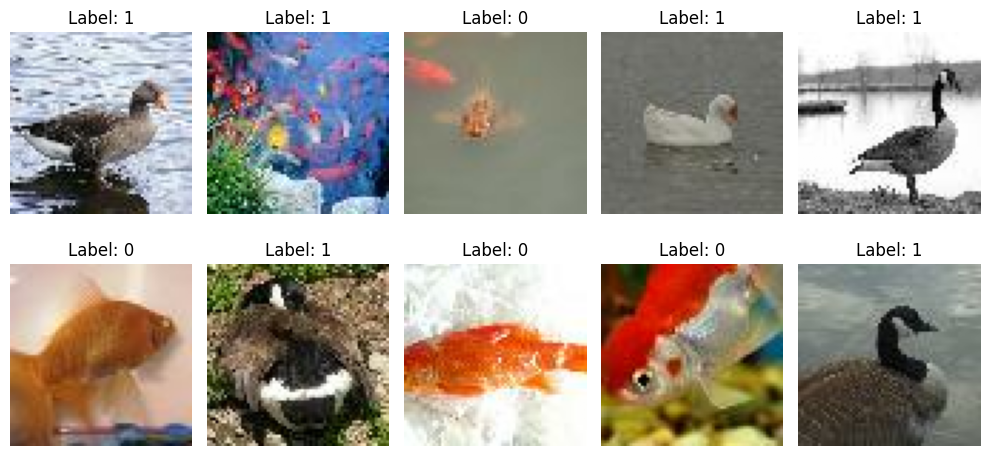

In [21]:
plot_predictions(model, val_ds)